### Table of Contents
* 1. Introduction
* 2. Code
    * 2.1 Basic Imports
    * 2.2 Binary Thresholding
    * 2.3 Warping
    * 2.4 Identifying Lane Pixels using Histogram Representation of Images
    * 2.5 Identifying Lane Pixels using Polynomials
    * 2.6 Polynomial Fitting on Image
    * 2.7 Finding Road Radius of Curvature (Bonus)
    * 2.8 Estimating the vehicle position 
    * 2.9 Project Lane Info onto Image
    * 2.10 Lane Finding Pipeline
* 3. Using our Code to Detect Edges on Sample Videos

#### 1. Introduction

Lane detection is the task of detecting lanes on a road from a camera.  
In this notebook, we aim to detect lanes through a series of image processing steps broken down in the *Code* section.

#### 2. Code
In this section we'll break down our pipeline into several functions that eventually make up our pipeline to detect lanes successfully.

#### 2.1 Basic Imports


In [ ]:
#import libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
from moviepy.editor import VideoFileClip
%matplotlib inline

#### 2.2 Binary Thresholding
Binary Thresholding is an image processing method that creates a bitonal (aka binary) image based on setting a threshold value on the pixel intensity of the original image. 

In [ ]:
def binary_thresholded(img):
    # Transform image to gray scale
    gray_img =cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #cv2.imshow("gray_img",gray_img)
    
    # Apply sobel (derivative) in x direction, this is usefull to detect lines that tend to be vertical
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    
    #cv2.imshow("sobelx",sobelx)
    abs_sobelx = np.absolute(sobelx)
    #cv2.imshow("abs_sobelx",abs_sobelx)
    
    # Scale result to 0-255
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    #cv2.imshow("scaled_sobel",scaled_sobel)
    sx_binary = np.zeros_like(scaled_sobel)
    
    # Keep only derivative values that are in the margin of interest
    sx_binary[(scaled_sobel >= 30) & (scaled_sobel <= 255)] = 1
   
    # Detect pixels that are white in the grayscale image
    white_binary = np.zeros_like(gray_img)
    white_binary[(gray_img > 200) & (gray_img <= 255)] = 1
    #cv2.imshow("white_binary",white_binary)

    # Convert image to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # Convert image to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    H = hls[:,:,0]
    L=hls[:,:,1]
    S = hls[:,:,2]
    V=hsv[:,:,2]

    sat_binary = np.zeros_like(S)
    # Detect pixels that have a high saturation value
    sat_binary[(S > 90) & (S <= 255)] = 1

    hue_binary =  np.zeros_like(H)
    hue_binary[(H > 10)&(H<25)] = 1

    light_binary =  np.zeros_like(L)
    light_binary[(L>200)]=1

    v_binary=np.zeros_like(V)
    v_binary[(V>50)&(V<100)]=1


    # Try different combinations
    binary_1 = cv2.bitwise_or(sx_binary, white_binary)
    binary = cv2.bitwise_or(binary_1, sat_binary)

    return binary

**Example on output of binary thresholding function on one of the test images:**

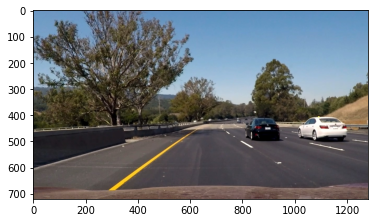

In [ ]:
# Original image before thresholding
image = cv2.imread('test_images/test6.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

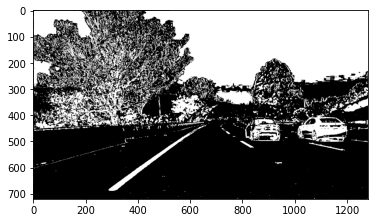

In [ ]:
binary_thresh = binary_thresholded(image)
out_img = np.dstack((binary_thresh, binary_thresh, binary_thresh))*255
plt.imshow(out_img, cmap='gray')

#### 2.3 Warp
In this function we will do **perspective Transform** from Car Camera to *Bird's Eye View*. 

In [ ]:
def warp(img):
    #The input is binary image
    img_size = (img.shape[1], img.shape[0])
    offset = 300
    
    # Source points taken from images with straight lane lines, these are to become parallel after the warp transform
    src = np.float32([
        (190, 720), # bottom-left corner
        (596, 447), # top-left corner
        (685, 447), # top-right corner
        (1125, 720) # bottom-right corner
    ])
    # Destination points are to be parallel, taken into account the image size
    dst = np.float32([
        [offset, img_size[1]],             # bottom-left corner
        [offset, 0],                       # top-left corner
        [img_size[0]-offset, 0],           # top-right corner
        [img_size[0]-offset, img_size[1]]  # bottom-right corner
    ])
    # Calculate the transformation matrix and it's inverse transformation
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size)
  
    return warped, M_inv

**Example on output of warping function on the same test image as before:**

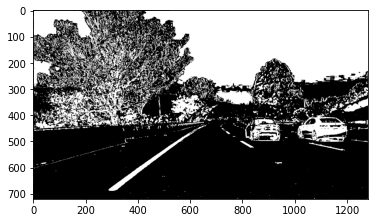

In [ ]:
binary_warped, M_inv = warp(binary_thresh)
plt.imshow(out_img, cmap='gray')

#### 2.4 Identifying Lane Pixels using Histogram Representation of Images
Detection of Lane Lines Using Histogram representation.  

An image histogram is a graphical representation of the number of pixels in an image as a function of their intensity. Histograms are made up of bins, each bin representing a certain intensity value range.

In [ ]:
def find_lane_pixels_using_histogram(binary_warped):

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

#### 2.5 Identifying Lane Pixels using Polynomials
In this function we fit a second order polynomial to each line.

In [ ]:
def fit_poly(binary_warped,leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)   
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fit, right_fit, left_fitx, right_fitx, ploty


**Now we'll find the second order polynomial we have created to each line.**

#### 2.6 Polynomial Fitting on Image
**Find lane pixels using the polynomial we have just created above.**

In [ ]:
def find_lane_pixels_using_prev_poly(binary_warped):
    global prev_left_fit
    global prev_right_fit
    # width of the margin around the previous polynomial to search
    margin = 100
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + 
                    prev_left_fit[2] - margin)) & (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + 
                    prev_left_fit[1]*nonzeroy + prev_left_fit[2] + margin))).nonzero()[0]
    right_lane_inds = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + 
                    prev_right_fit[2] - margin)) & (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + 
                    prev_right_fit[1]*nonzeroy + prev_right_fit[2] + margin))).nonzero()[0]
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]


**The below function is used to draw the poly lines of the edges:**

In [ ]:
def draw_poly_lines(binary_warped, left_fitx, right_fitx, ploty):     
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
        
    margin = 100
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (100, 100, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (100, 100, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='green')
    plt.plot(right_fitx, ploty, color='blue')
    ## End visualization steps ##
    return result

In [ ]:
global left_fit_hist 
left_fit_hist = np.array([])

global right_fit_hist 
right_fit_hist = np.array([])

**Example on output of poly_fit function on the test image:**

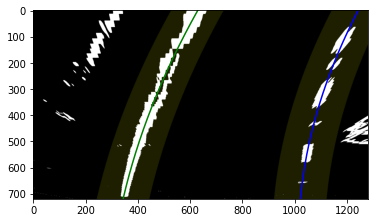

In [ ]:
leftx, lefty, rightx, righty = find_lane_pixels_using_histogram(binary_warped)
left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped,leftx, lefty, rightx, righty)

out_img = draw_poly_lines(binary_warped, left_fitx, right_fitx, ploty)
plt.imshow(out_img)
prev_left_fit, prev_right_fit = left_fit, right_fit

#### 2.7 Finding Road Radius of Curvature (Bonus)

In [ ]:
def measure_curvature_meters(binary_warped, left_fitx, right_fitx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

**Example on Estimation of road radius of curvature:**

In [ ]:
left_curverad, right_curverad =  measure_curvature_meters(binary_warped, left_fitx, right_fitx, ploty)
print('left curve radius in meters  = ', left_curverad)

print('right curve radius in meters = ', right_curverad)

left curve radius in meters  =  721.1181342949927
right curve radius in meters =  559.4280158462913


#### 2.8 Estimating the vehicle position 
**We do that by estimating how far the vehicle is from the center of the lane.**

In [ ]:
def measure_position_meters(binary_warped, left_fit, right_fit):
    # Define conversion in x from pixels space to meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Choose the y value corresponding to the bottom of the image
    y_max = binary_warped.shape[0]
    # Calculate left and right line positions at the bottom of the image
    left_x_pos = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    right_x_pos = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2] 
    # Calculate the x position of the center of the lane 
    center_lanes_x_pos = (left_x_pos + right_x_pos)//2
    # Calculate the deviation between the center of the lane and the center of the picture
    # The car is assumed to be placed in the center of the picture
    # If the deviation is negative, the car is on the felt hand side of the center of the lane
    veh_pos = ((binary_warped.shape[1]//2) - center_lanes_x_pos) * xm_per_pix 
    return veh_pos

global temp

**Example on Estimation of vehicle position:**

In [ ]:
veh_pos = measure_position_meters(binary_warped, left_fit, right_fit)
print('vehicle position relative to center  = ', veh_pos)

vehicle position relative to center  =  -0.222


#### 2.9 Project Lane Info onto Image
**In this function we project Lane delimitations back on image plane and add text for lane info.**

In [ ]:
def project_lane_info(img, binary_warped, ploty, left_fitx, right_fitx, M_inv, left_curverad, right_curverad, veh_pos):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])


    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0]))
   
    # Combine the result with the original image
    out_img = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    cv2.putText(out_img,'Curve Radius [m]: '+str((left_curverad+right_curverad)/2)[:7],(40,70), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6, (255,255,255),2,cv2.LINE_AA)
    cv2.putText(out_img,'Center Offset [m]: '+str(veh_pos)[:7],(40,150), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6,(255,255,255),2,cv2.LINE_AA)

    return out_img,newwarp

**Example on Projecting lane info onto the image:**

Text(0.5, 1.0, 'Image With Lane Marked')

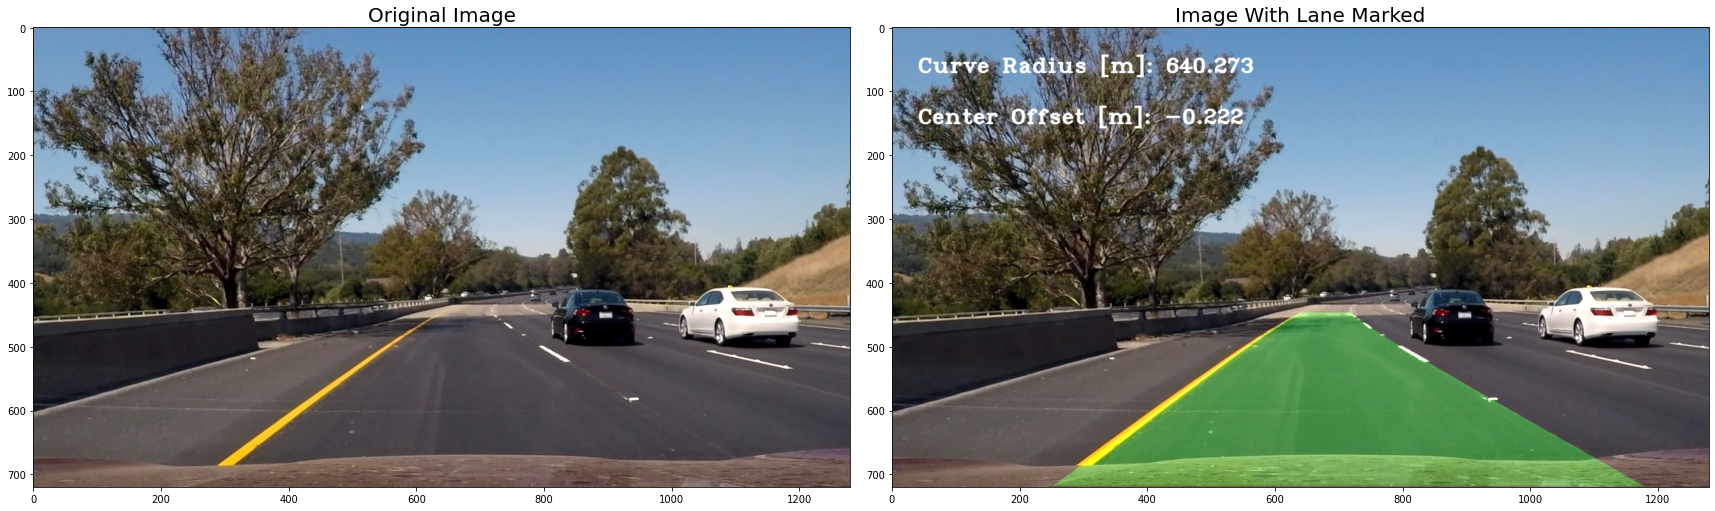

In [ ]:
new_img = project_lane_info(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), binary_warped, ploty, left_fitx, right_fitx, M_inv, left_curverad, right_curverad, veh_pos)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(new_img[0], cmap='gray')
ax2.set_title('Image With Lane Marked', fontsize=20)

#### 2.10 Lane Finding Pipeline
**Complete pipeline to detect lanes using the previously implemented functions above.**

In [ ]:
global left_fit_hist 
left_fit_hist = np.array([])

global right_fit_hist 
right_fit_hist = np.array([])

In [ ]:
def lane_finding_pipeline(img,isDebug):
    global left_fit_hist 
    global right_fit_hist
    global prev_left_fit
    global prev_right_fit
    global temp

    #Step 1
    binary_thresh = binary_thresholded(img)
    
    #Step 2
    binary_warped, M_inv = warp(binary_thresh)
    #out_img = np.dstack((binary_thresh, binary_thresh, binary_thresh))*255
    
    #Step 3
    #Find Lane from the histogram if it is the first frame
    if (len(left_fit_hist) == 0):
        temp = np.zeros_like(img)
        # loop over the image, pixel by pixel
        for y in range(0, 720):
            for x in range(0, 1280):
                # threshold the pixel
                temp[y, x] = 255 if y>500 else 0
        leftx, lefty, rightx, righty = find_lane_pixels_using_histogram(binary_warped)
        left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped,leftx, lefty, rightx, righty)
        # Store fit in history
        left_fit_hist = np.array(left_fit)
        new_left_fit = np.array(left_fit)
        left_fit_hist = np.vstack([left_fit_hist, new_left_fit])
        right_fit_hist = np.array(right_fit)
        new_right_fit = np.array(right_fit)
        right_fit_hist = np.vstack([right_fit_hist, new_right_fit])
    #Find Lane from the previous polynomial if it is not the first frame
    else:
        prev_left_fit = [np.mean(left_fit_hist[:,0]), np.mean(left_fit_hist[:,1]), np.mean(left_fit_hist[:,2])]
        prev_right_fit = [np.mean(right_fit_hist[:,0]), np.mean(right_fit_hist[:,1]), np.mean(right_fit_hist[:,2])]
        leftx, lefty, rightx, righty = find_lane_pixels_using_prev_poly(binary_warped)
        if (len(lefty) == 0 or len(righty) == 0):
            leftx, lefty, rightx, righty = find_lane_pixels_using_histogram(binary_warped)
        left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped,leftx, lefty, rightx, righty)
        
        # Add new values to history
        new_left_fit = np.array(left_fit)
        left_fit_hist = np.vstack([left_fit_hist, new_left_fit])
        new_right_fit = np.array(right_fit)
        right_fit_hist = np.vstack([right_fit_hist, new_right_fit])
        
        # Remove old values from history
        if (len(left_fit_hist) > 10):
            left_fit_hist = np.delete(left_fit_hist, 0,0)
            right_fit_hist = np.delete(right_fit_hist, 0,0)
                                       
    left_curverad, right_curverad =  measure_curvature_meters(binary_warped, left_fitx, right_fitx, ploty)
    veh_pos = measure_position_meters(binary_warped, left_fit, right_fit) 
    out_img,new_warp = project_lane_info(img, binary_warped, ploty, left_fitx, right_fitx, M_inv, left_curverad, right_curverad, veh_pos)

    if isDebug =="1":
        #Display the output with the pipeline
        binary_thresh[binary_thresh==1]=255
        binary_thresh=cv2.cvtColor(binary_thresh,cv2.COLOR_GRAY2BGR)
        binary_thresh=cv2.resize(binary_thresh,(0,0),None,1/3,1/3)

        binary_warped[binary_warped==1]=255
        binary_warped=cv2.cvtColor(binary_warped,cv2.COLOR_GRAY2BGR)
        binary_warped=cv2.resize(binary_warped,(0,0),None,1/3,1/3)


        new_warp=cv2.resize(new_warp,(0,0),None,1/3,1/3)
        
        out_img=cv2.resize(out_img,(0,0),None,2/3,1)
        temp_img=cv2.vconcat([binary_thresh,binary_warped,new_warp])
        concatenated_out=cv2.hconcat([out_img, temp_img])

        return concatenated_out
    else:
        return out_img

#### 3. Using our Code to Detect Edges on Sample Videos
Here the user will input the source file path as well as desired output video path.   
Then we'll detect lanes and color the lane area with green then cast it on the original video.

In [ ]:
##Working on an input video

src_path='test_video/project_video.mp4'
dstn_path='processing_result'
cap=cv2.VideoCapture(src_path)

fps=cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH )
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT )
frameSize = (int(width), int(height))

out = cv2.VideoWriter(dstn_path,0x7634706d , fps, frameSize)

i=0
while(cap.isOpened()):
    i=i+1
    ret,frame=cap.read()
    if ret==1:
        #Call the pipeline in a single the captured frame from the video
        out_frame=lane_finding_pipeline(frame,0)
        out.write(out_frame)
        print("Producing output video, ",int((i/frame_count)*100),"% completed.", end='\r')

        #cv2.imshow("output",out_frame)
        #if cv2.waitKey(1)&0xFF==ord('q'):
        #    break
    else:
        print("Video has been Produced")
        break

cap.release()
out.release()
cv2.destroyAllWindows()